# Poisson spiking basics


Here we are dealing with homogeneous Poisson processes. See http://www.cns.nyu.edu/~david/handouts/poisson.pdf for an excellent introduction relevant to neuroscience. 

Spikes are irregular. A wildely used model for spike trains is a Poisson spike train. The spiking is controlled by a single rate parameter, $r(t)$. For a 'homogeneous' Poisson proces $r(t)$, and thus the spike rate, is constant. The probability of 'no spike' obeys  

$$\frac{dp_o}{dt} = -rp_o$$ 

The interspike interval (isi) is therefore exponentially distributed with density function:

$$ p_o(t) = re^{-rt}$$

The mean isi is then:

$$ \langle t_{isi} \rangle = \int_0^\infty tp_o(t)dt = r^{-1}$$

The number of spikes in interval $(t_1, t_2)$ is:

$$\langle n \rangle = \int_{t_1}^{t_2} r dt= r(t_2-t_1)$$

And the probability of n spikes in the same interval is given by the famous Poisson distribution:

$$ p(n, (t_1, t_2))= e^{-\langle n \rangle}\frac {\langle n \rangle}{n!}$$


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#%%time

def poisson_spks_ms(t, r, rp):
# returns an array of spike times discretized to 1 ms in time
# assume 1 ms binning; t in ms
# r - poisson spike rate in Hz
# rp - refractory period in ms
    numbers=np.random.uniform(size=t)
    temp=np.where(numbers < r/1000.0)[0] # note: np.where returns a tuple
    ind=np.where(np.diff(temp)>rp)[0] # find isis longer than refractory period
    temp=temp[np.append(ind, len(temp)-1)]
    return temp

trials = 1000
duration = 10000 # trial duration in ms
refractory_period = 5 # in ms
rate =5 # in Hz

spk_trains = []
for ii in np.arange(trials):
    spks = poisson_spks_ms(duration, rate, refractory_period)
#    plt.plot(spks, (ii+1)*np.ones(len(spks)), 'k.')
    spk_trains.append(spks)

    

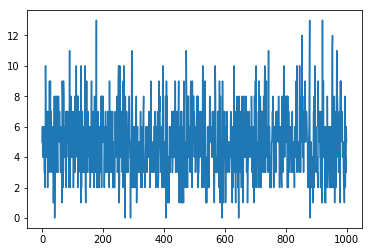

In [4]:
# peristimulus time histogram
all_spks=np.array([])
for spks in spk_trains:
    all_spks=np.append(all_spks, spks)

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_spks, bins)

plt.plot(bin_edges[0:1000], hg[0:1000])

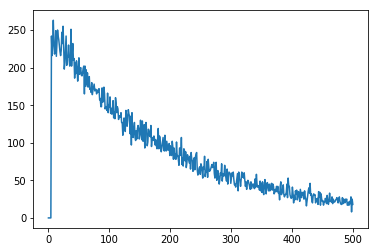

In [5]:
# Compute isi histogram function 

all_isi=np.array([])
for spks in spk_trains:
    all_isi=np.append(all_isi, np.diff(spks))

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_isi, bins)

plt.plot(bin_edges[0:500], hg[0:500])  


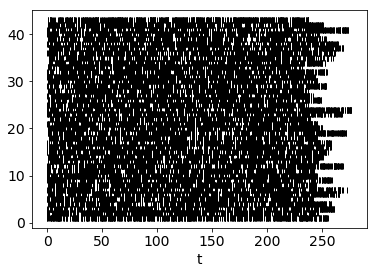

In [6]:
# alternative way to produce poisson spike trains
# using the exponential distribution

import numpy as np
import matplotlib.pyplot as plt

alpha=.5 # time constant; 1/rate
npts=22000 #
refractory_period = 0.005 # s 
#runs=10 #

isi=np.random.exponential(scale=alpha,size=(npts))

# find short isis and remove them -- i.e. refractory period
shorts=np.where(isi < refractory_period)
isi=np.delete(isi, shorts)

sp_times=np.cumsum(isi)

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("t")

delta=0
last=0
rast=500
while (rast + delta*rast) < len(sp_times): 
    spks = sp_times[(0+rast*delta):(rast+rast*delta)]-last
    plt.plot(spks, (delta+1)*np.ones(len(spks)), 'k|')
    last=last+spks[-1]
    delta+=1

# to do
# trials of duration T with Poisson spikes

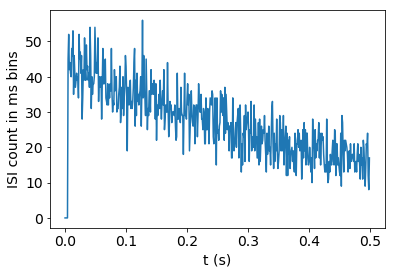

In [7]:

# histogram, 1 ms bins
bins=np.arange(0, 1, 0.001)
(hg, bin_edges)=np.histogram(isi, bins)

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("t (s)")
plt.ylabel("ISI count in ms bins")

plt.plot(bin_edges[0:500], hg[0:500])

#type(bin_edges)

# Spike sorting metrics: what do they mean?


Here we consider the standard spike sorting quality metric $Q$, corresponding to the proportion of spikes in refractory period $T_r$. What does this mean in terms of false positive rates $fp$?

Let $r_o$ be the rate of the primary neuron and $r_1$ the rate of detection of the polluting neurons by the spike sorting system, $r_1=\sum r_i$ (all Poisson neurons). Then the total spikes produced by these neurons in interval $T$ is $N_o = r_oT$ and $N_1=r_1T$. 

Now, the probability of a spike from the polluting neurons in $T_r$ after a spike from the primary neuron is $p_1=r_1T_r$. Therefore the number of spikes in Tr following spikes from the primary neuron is 
$$n_o=r_1T_rr_oT$$
Similarly, the number of spikes in Tr following spikes from the polluting neuron is 
$$n_1=r_oT_rr_1T$$
The number of counts in the refractory period is the sum:
$$n_r=2r_or_1TT_r$$

The spirk sorting quality metric is:

$$Q=\frac{n_r}{N_o+N_1}= \frac{2r_or_1T_r}{r_o+r_1}$$

The false positive rate is 

$$fp=\frac{N_1}{N_1+N_o}=\frac{r_1}{r_1+r_o}$$

Therefore,

$$fp=\frac{Q}{2r_oT_r}$$

For example, assume $Q = 0.01$, $r_o=5Hz$ and $T_r=5 ms$, then $fp=0.2$.

Q =  0.010114930573612773
fp rate =  0.5
count in rp n_r = 389 ; expected n_r =  400.0


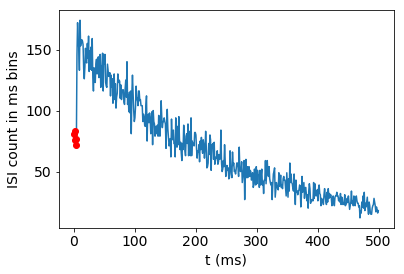

In [8]:
trials = 1000
duration = 10000 # trial duration in ms
rp = 5 # in ms
rate0 =2.0 # in Hz
rate1 =2.0 # in Hz; polluting spikes

spk_trains = []
for ii in np.arange(trials):
    spks=poisson_spks_ms(duration, rate0, rp)
    spks=np.append(spks, poisson_spks_ms(duration, rate1, rp))
    spks=np.sort(spks)
    #    plt.plot(spks, (ii+1)*np.ones(len(spks)), 'k.')
    spk_trains.append(spks)

all_isi=np.array([])
for spks in spk_trains:
    all_isi=np.append(all_isi, np.diff(spks))

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_isi, bins)

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("t (ms)")
plt.ylabel("ISI count in ms bins")

plt.plot(bin_edges[0:500], hg[0:500])
plt.plot(bin_edges[0:5], hg[0:5],'ro')

print('Q = ', np.sum(hg[0:5])/np.sum(hg))
print('fp rate = ',rate1/(rate0+rate1))
print('count in rp n_r =', np.sum(hg[0:round(rp)]), '; expected n_r = ', 
      2*rate0*rate1*trials*duration*rp/(1000*1000))    

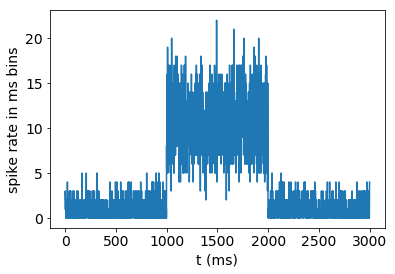

In [9]:
# new problem
# now let's assume that we have a strongly modulated background unit at mean rate r_1
trials = 1000
duration0 = 10000 # trial duration in ms
duration1 = 1000 # duration of high activity, from 1-2 sec; low otherwise 
rp = 5 # in ms
rate0 =1.0 # in Hz
rate1 =10.0 # in Hz; polluting spikes

spk_trains = []
for ii in np.arange(trials):
    spks=poisson_spks_ms(duration0, rate0, rp)
    spks=np.append(spks, (1000.0+poisson_spks_ms(duration1, rate1, rp))) 
        # Polluting unit produced high spike rates for 1 s with 1 s delay 
    spks=np.sort(spks)
    #    plt.plot(spks, (ii+1)*np.ones(len(spks)), 'k.')
    spk_trains.append(spks)

all_spks=np.array([])
for spks in spk_trains:
    all_spks=np.append(all_spks, spks)

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_spks, bins)

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("t (ms)")
plt.ylabel("spike rate in ms bins")

plt.plot(bin_edges[0:3000], hg[0:3000]) 
    

Q =  0.005129604365620737
fp rate =  0.9090909090909091
count in rp n_r = 94 ; expected n_r =  1000.0


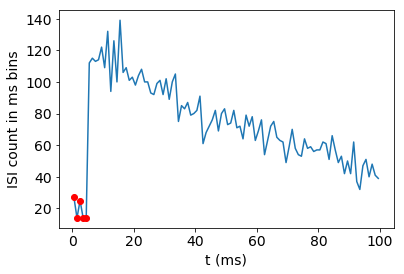

In [10]:
all_isi=np.array([])
for spks in spk_trains:
    all_isi=np.append(all_isi, np.diff(spks))

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_isi, bins)

plt.plot(bin_edges[0:100], hg[0:100])
plt.plot(bin_edges[0:5], hg[0:5],'ro')

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("t (ms)")
plt.ylabel("ISI count in ms bins")

print('Q = ', np.sum(hg[0:5])/np.sum(hg))
print('fp rate = ',rate1/(rate0+rate1))
print('count in rp n_r =', np.sum(hg[0:round(rp)]), '; expected n_r = ', 
      2*rate0*rate1*trials*duration*rp/(1000*1000)) 